# Figures Notebook

## Packages

We begin by loading in necessary software packages and introducing options for saving the results.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe

from scipy.stats import spearmanr
from scipy.ndimage.filters import gaussian_filter1d

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF input file
input_name = '../results/zinser_results_full.nc'

# write out generated plots
save_plots = True

## Load Data

In [3]:
# Load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]

# create "counts" entry
if 'count' in data_gridded:
    data_gridded['counts'] = (data_gridded['count'][None,:]
                              * data_gridded['w_obs']).astype(int)
elif 'abundance' in data_gridded:
    logging.warning('Using "abundance" data to generate count data.')
    data_gridded['counts'] = (data_gridded['count'][None,:]
                              * data_gridded['w_obs']).astype(int)
else:
    raise RuntimeError('Cannot find a "count" or "abundance" entry.')


# add description
desc += (' (m={data[m]}, $\Delta_v^{{-1}}$='
                   + '{data[delta_v_inv]})'.format(data=data_gridded))

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [4]:
# Ground truth division, carbon fixation, carbon loss measured/estimated from the Zinser et al. dataset
ground_truth = {}
with nc4.Dataset('../data/ground_truth/zinser_ground_truth.nc') as nc:
    for var in nc.variables:
        ground_truth[var] = nc.variables[var][:]

# Measurements and standard errors including photosynthetic parameters from Zinser et al. paper figure 3
zinser_fig3 = pd.read_csv('../data/ground_truth/zinser_figure3.csv')

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


## Process Data

In [5]:
# Additional data processing to prepare data for Stan model
if 'data' not in globals():
    data = {}

dt = 20  # Time discretization parameter in units of minutes

data = {'dt':dt}

# Discrete size classes
for v in ('m','v_min','delta_v_inv'):
    data[v] = data_gridded[v]

limit_days = 2  # Number of days for which fitting is performed

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
par = data_gridded['PAR']

if limit_days > 0:
    limit_minutes = limit_days*1440

    ind_obs = data['t_obs'] < limit_minutes

    if not np.all(ind_obs):
        print('limit_days is set to {}, removing {}/{} observation times'.format(limit_days,
                                                                                 ind_obs.size-np.count_nonzero(ind_obs),
                                                                                 ind_obs.size))

    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])

data['nt_obs'] = data['t_obs'].size

# add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=par)

# real count data
data['obs_count'] = data_gridded['counts'][:, ind_obs]

limit_days is set to 2, removing 1/25 observation times


## Model List

In [6]:
# Convert model keys to model names
desc_model = {
    'm_bmx': 'm$_\mathrm{bmx}$',
    'm_bmb': 'm$_\mathrm{bmb}$',
    'm_pmb': 'm$_\mathrm{pmb}$',
    'm_fmb': 'm$_\mathrm{fmb}$',
    'm_fmf': 'm$_\mathrm{fmf}$',
    'm_btb': 'm$_\mathrm{btb}$', 
    'm_ptb': 'm$_\mathrm{ptb}$', 
    'm_ftb': 'm$_\mathrm{ftb}$',
    'm_ftf': 'm$_\mathrm{ftf}$',
}

## Load Results

In [7]:
mcmcs = {}
with nc4.Dataset(input_name) as nc:
    models = nc.groups.keys()
    for name in models:
        if name not in mcmcs.keys():
            mcmcs[name] = {}
        for var in nc[name].variables:
            if 145 in nc[name].variables[var][:].shape:
                ind = np.where(np.asarray(nc[name].variables[var][:].shape) == 145)[0][0]
                if ind == 0:
                    mcmcs[name][var] = nc[name].variables[var][:-1]
                elif ind == 1:
                    mcmcs[name][var] = nc[name].variables[var][:, :-1]
                else:
                    raise ValueError('Unexpected index!')
            else:
                mcmcs[name][var] = nc[name].variables[var][:]

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel

## Some Plotting Parameters

In [8]:
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['figure.figsize'] = (7.5,7.5)
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# set the color for each model
mod_list = ['m_bmx', 'm_bmb', 'm_pmb', 'm_fmb', 'm_fmf', 'm_btb',
            'm_ptb', 'm_ftb', 'm_ftf']
# mod_list = ['m_bmx', 'm_bmb', 'm_pmb', 'm_fmf', 'm_ftf']

# Color blind-friendly model color coding scheme
color_palette = {
    'm_bmx': (51/255, 24/255, 136/255),
    'm_bmb': (136/255, 204/255, 238/255),
    'm_pmb': (68/255, 170/255, 153/255),
    'm_fmb': (17/255, 119/255, 51/255),
    'm_fmf': (153/255, 153/255, 51/255),
    'm_btb': (221/255, 204/255, 119/255),
    'm_ptb': (204/255, 102/255, 119/255),
    'm_ftb': (136/255, 34/255, 85/255),
    'm_ftf': (170/255, 68/255, 153/255),
}

colors_model = {model: color_palette[model] for model in mod_list}

In [9]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

if show_data:
    v_min = data_gridded['v_min']
    delta_v = 1.0/data_gridded['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded['m'])*delta_v)
    v_carbon = v*np.sqrt(2**(delta_v))

# Figures

### Daily parameter plot

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


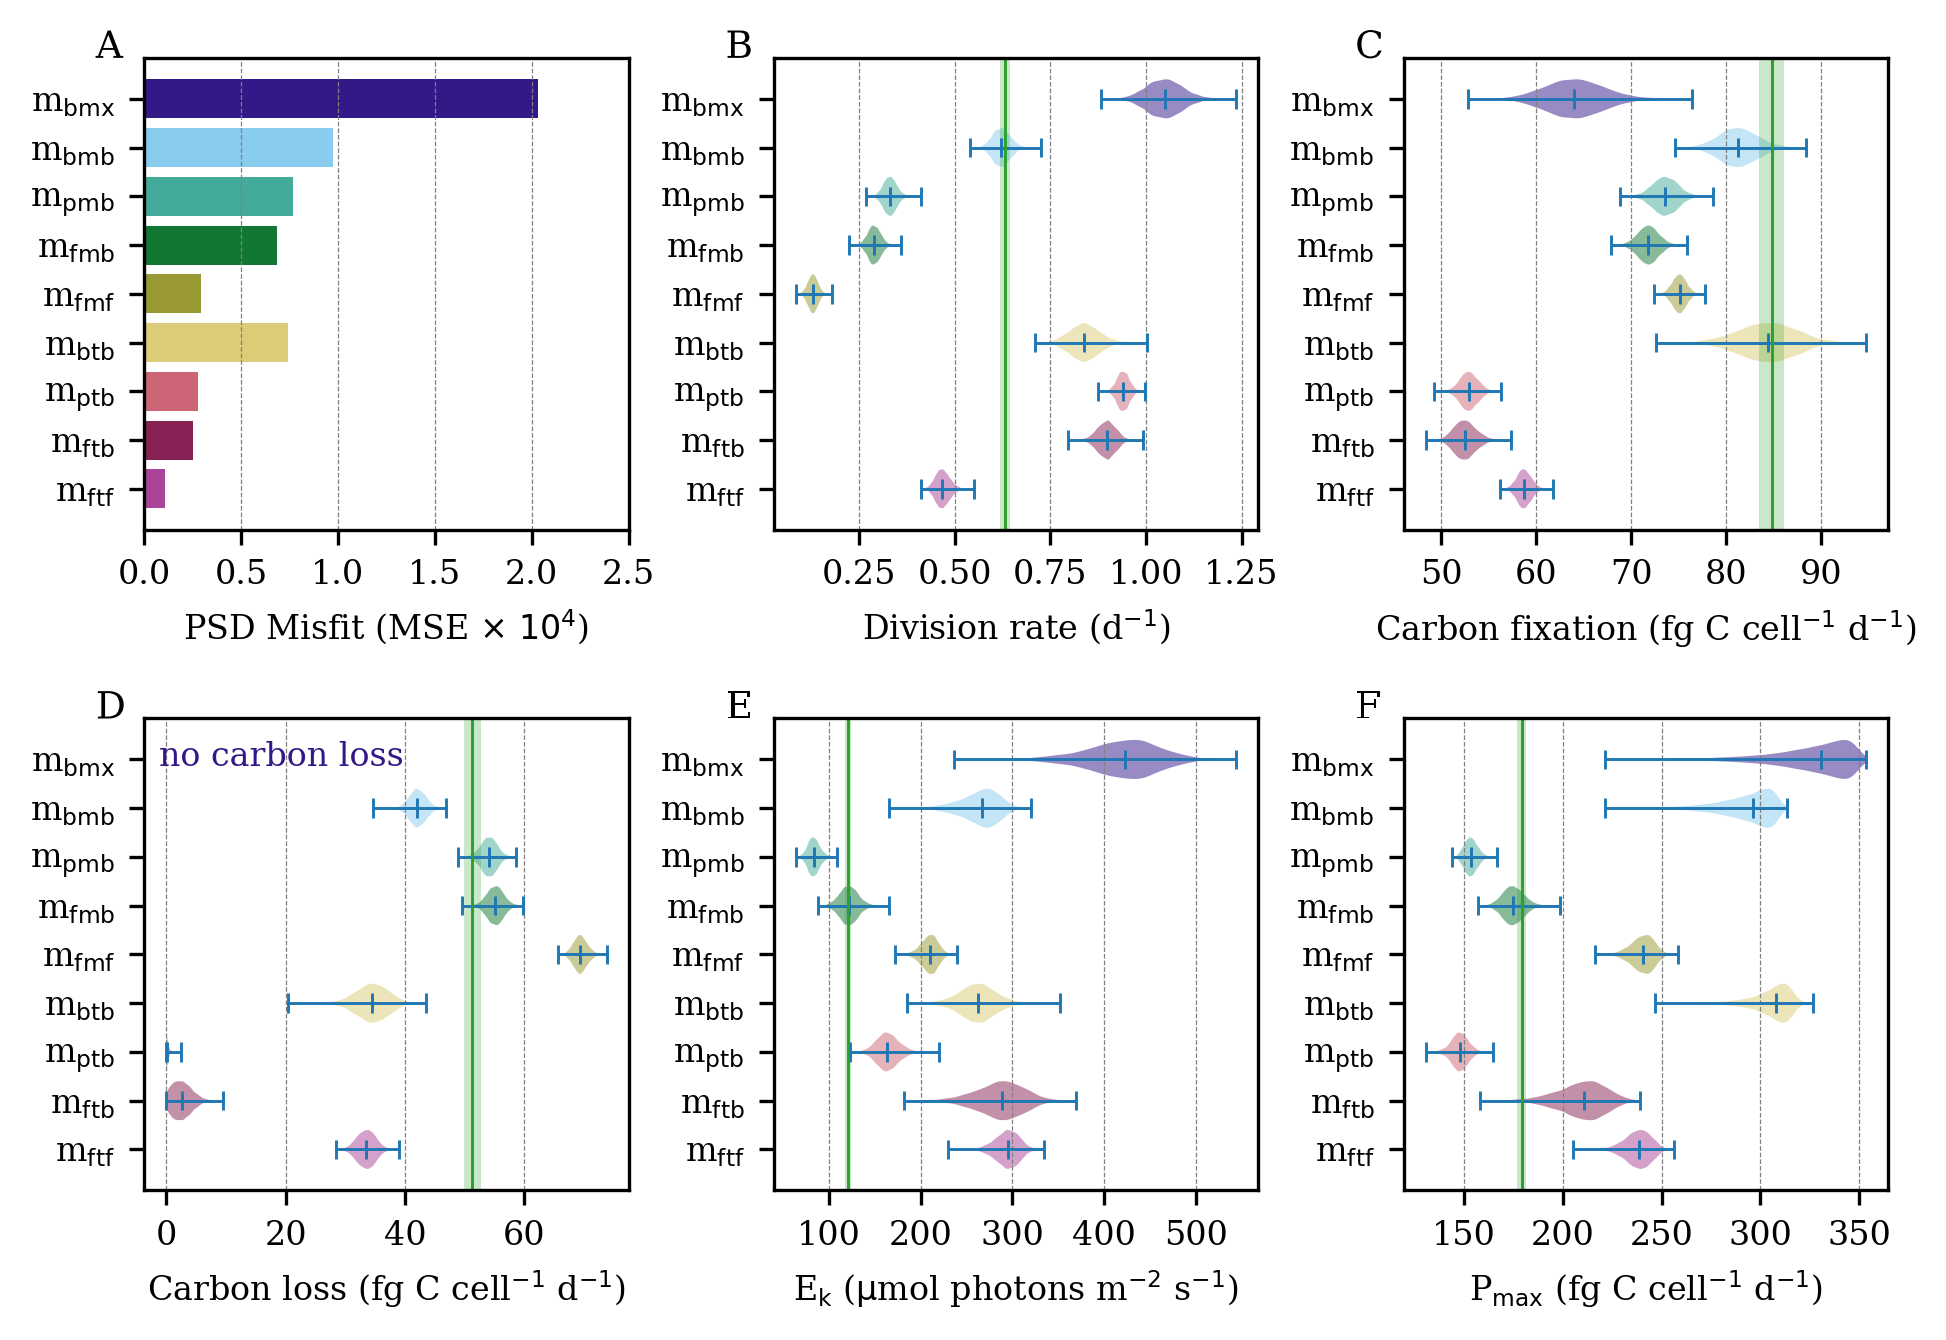

In [10]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

# Panel label parameters
xtext = -0.1
ytext = 1
text_color = 'black'

# Ground truth plotting parameters
truth_lw = 0.7
truth_alpha = 0.25
truth_color = 'tab:green'

# Model results plotting parameters
widths = 0.8
linewidth = 0.7
violin_alpha = 0.5

# Plot grid parameters
show_grid = True
grid_width = 0.3
which_grid = 'both'
grid_axis = 'x'
grid_color = 'grey'
grid_style = '--'


# Helper functions
def get_misfit(mcmcs, data):
    obs = data['obs']
    ee = np.zeros(len(mcmcs))
    for ii, model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        ee[ii] = np.mean((mod_mean-obs)**2)
    return ee


def color_violin(plot, colors, violin_alpha, linewidth):
    ii = 0
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(violin_alpha)
        ii += 1
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    return 0


def get_daily_props(mcmcs, prop, dt_h):
    
    res = {}

    for model in mcmcs:
        cell_count = mcmcs[model]['cell_count']
        if prop == 'growth':
            plotprop = mcmcs[model]['growth_size_gain']/cell_count/dt_h
        elif prop == 'respiration':
            plotprop = mcmcs[model]['resp_size_loss']/cell_count/dt_h
        else:
            raise ValueError('Unknown prop "{}"!'.format(prop))
        res[model] = np.mean(plotprop, axis=1)*24
    return res


# Gather results, initialize figure
temp_mcmcs = {key: mcmcs[key] for key in mcmcs if key in mod_list}
num_mcmcs = len(temp_mcmcs)
fig, axs = plt.subplots(2, 3, figsize=(7.5,5))


# Specify arrangement of figure panels
ax_misfit = axs[0, 0]
ax_div = axs[0, 1]
ax_grow = axs[0, 2]
ax_resp = axs[1, 0]
ax_estar = axs[1, 1]
ax_pmax = axs[1, 2]


# PSD misfit (MSE)
ax = ax_misfit

ee = get_misfit(temp_mcmcs, data)

ax.barh(y=np.arange(len(temp_mcmcs)), width=ee*10000,
        color=[colors_model[model] for model in temp_mcmcs])

ax.invert_yaxis()
ax.text(xtext, ytext, 'A', transform=ax.transAxes, color=text_color,
        fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.set(yticks=np.arange(0, num_mcmcs),
       yticklabels=[desc_model[model].replace(',',',\n')
                    for model in temp_mcmcs],
       xticks=np.linspace(0, 2.5, num=6))
ax.set_xlabel(r'PSD Misfit (MSE $\times ~ 10^4$)')
ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
        linestyle=grid_style, linewidth=grid_width)


# Daily division rates
ax = ax_div

plot = ax.violinplot([temp_mcmcs[model]['divrate']
                      for model in temp_mcmcs],
                     showmedians=True, vert=False, widths=widths)

colors = [colors_model[model] for model in temp_mcmcs]

color_violin(plot, colors, violin_alpha, linewidth)

ax.invert_yaxis()
ax.set(yticks=np.arange(1, num_mcmcs+1),
       yticklabels=[desc_model[model].replace(',',',\n')
                    for model in temp_mcmcs],
       xlabel='Division rate (d$^{-1}$)')
ax.set_xticks(np.linspace(0, 1.25, num=6), minor=False)

ax.text(xtext, ytext, 'B', transform = ax.transAxes, color=text_color,
        fontsize=fontsize, path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)

if 'zinser' in dataname:
    ax.axvline(ground_truth['dailydivision'], color=truth_color, lw=truth_lw)
    ax.axvspan(ground_truth['dailydivision']-ground_truth['dailydivision_sd'],
               ground_truth['dailydivision']+ground_truth['dailydivision_sd'],
               facecolor='tab:green', alpha=truth_alpha)


# Daily growth/respiration
dt_h = data['dt'] / 60.0
daily_props = {}
xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
           'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
labels = {'growth': 'C', 'respiration': 'D'}
par_string = {'growth': 'carbonfix', 'respiration': 'carbonloss'}

for prop in ('growth', 'respiration'):

    daily_props[prop] = get_daily_props(temp_mcmcs, prop, dt_h)

    if prop == 'respiration':
        ax = ax_resp
        plot = ax.violinplot([daily_props[prop][model]
                              for model in daily_props[prop]
                              if model != 'm_bmx'],
                             showmedians=True, vert=False, widths=widths)

        colors = [colors_model[model] for model in temp_mcmcs
                  if model != 'm_bmx']

        ax.set_ylim(-0.84, num_mcmcs-0.16)
        ax.set_yticks(np.arange(0, num_mcmcs))
        ax.text(0.03, 1-1/(num_mcmcs+1), 'no carbon loss', transform = ax.transAxes,
                color=colors_model['m_bmx'], fontsize=8)
        ax.set_xticks(np.linspace(0, 60, num=4))

    elif prop == 'growth':

        ax = ax_grow

        plot = ax.violinplot([daily_props[prop][model]
                              for model in daily_props[prop]],
                             showmedians=True, vert=False, widths=widths)

        colors = [colors_model[model] for model in temp_mcmcs]

        ax.set_yticks(np.arange(1, num_mcmcs+1))
        ax.set_xticks(np.linspace(50, 90, num=5))

    ax.set(yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel=xlabels[prop])
    ax.invert_yaxis()

    color_violin(plot, colors, violin_alpha, linewidth)

    ax.text(xtext, ytext, labels[prop], transform = ax.transAxes,
            color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
    ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
            linestyle=grid_style, linewidth=grid_width)

    ax.axvline(ground_truth['daily' + par_string[prop]],
               color=truth_color, lw=truth_lw)
    ax.axvspan(ground_truth['daily' + par_string[prop]]
               - ground_truth['daily' + par_string[prop] + '_sd'],
               ground_truth['daily' + par_string[prop]]
               + ground_truth['daily' + par_string[prop] + '_sd'],
               facecolor='tab:green', alpha=truth_alpha)


# Ek/Estar
ax = ax_estar

linewidth = 0.7

plot = ax.violinplot([temp_mcmcs[model]['E_star']
                      for model in temp_mcmcs],
                     showmedians=True, vert=False, widths=0.8)
colors = [colors_model[model] for model in temp_mcmcs]

color_violin(plot, colors, violin_alpha, linewidth)

ax.invert_yaxis()
ax.set(yticks=np.arange(1, num_mcmcs+1),
       yticklabels=[desc_model[model].replace(',',',\n')
                    for model in temp_mcmcs],
       xlabel='E$_\mathrm{k}$ ($\mathrm{\mu}$mol photons m$^{-2}$ s$^{-1}$)')
ax.set_xticks(np.linspace(100, 500, num=5), minor=False)

ax.text(xtext, ytext, 'E', transform = ax.transAxes, color=text_color,
        fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
        linestyle=grid_style, linewidth=grid_width)

true_Estar = np.mean(np.asarray(zinser_fig3['Estar']))
Estar_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Estar-sd'])**2)
                   / (np.asarray(zinser_fig3['Estar-sd']).shape[0]**2))
ax.axvline(true_Estar, color=truth_color, lw=truth_lw)
ax.axvspan(true_Estar - Estar_sd, true_Estar + Estar_sd,
           facecolor=truth_color, alpha=truth_alpha)


# Pmax
ax = ax_pmax

t = data['dt']*np.arange(data['nt'])/60.0
dt_h = data['dt']/60.0
linewidth = 0.7

pmax = [np.mean(temp_mcmcs[model]['max_size_gain']
                / temp_mcmcs[model]['cell_count'] / dt_h,
                axis=1) * 24 for model in temp_mcmcs]

plot = ax.violinplot(pmax, showmedians=True, vert=False, widths=0.8)

colors = [colors_model[model] for model in temp_mcmcs]

color_violin(plot, colors, violin_alpha, linewidth)

ax.invert_yaxis()
ax.set(yticks=np.arange(1, num_mcmcs+1),
       yticklabels=[desc_model[model].replace(',',',\n')
                    for model in temp_mcmcs],
       xticks=np.linspace(150, 350, 5),
       xlabel='P$_\max$ (fg C cell$^{-1}$ d$^{-1}$)')

ax.text(xtext, ytext, 'F', transform = ax.transAxes, color=text_color,
        fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color,
        linestyle=grid_style, linewidth=grid_width)

true_pmax = np.mean(np.asarray(zinser_fig3['Pmax'])) * 24
pmax_sd = np.sqrt(np.sum(np.asarray(zinser_fig3['Pmax-sd'])**2)
                  / (np.asarray(zinser_fig3['Pmax-sd']).shape[0]**2)) * 24
ax.axvline(true_pmax, color=truth_color, lw=truth_lw)
ax.axvspan(true_pmax-pmax_sd, true_pmax+pmax_sd, facecolor=truth_color,
           alpha=truth_alpha)


plt.subplots_adjust(hspace=0.4, wspace=0.3)
if save_plots:
    plt.savefig('../figures/zinser_daily_full.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Hourly parameter plot

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator


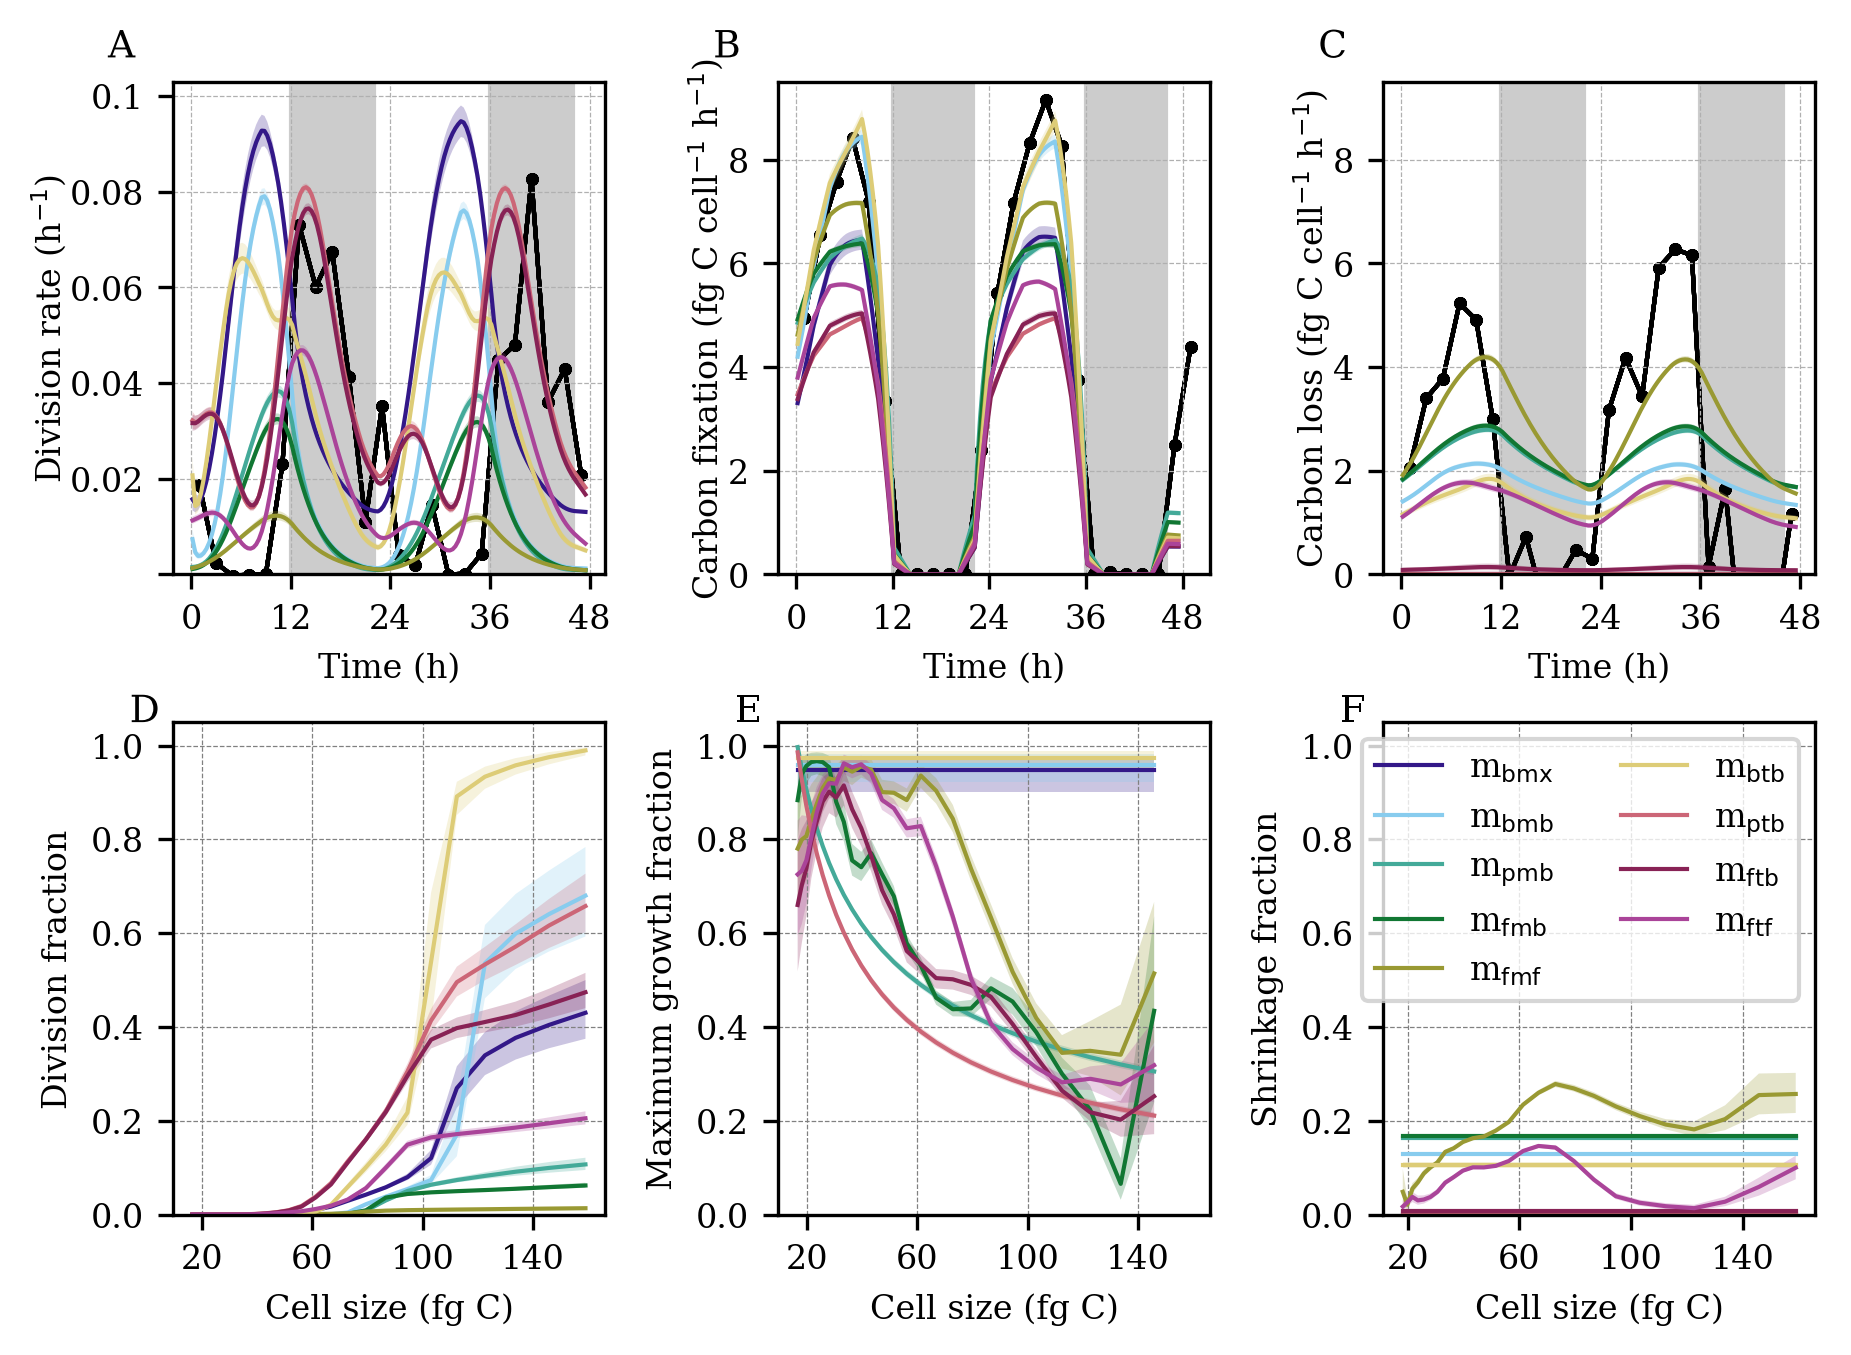

In [11]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'Carbon fixation ({} h$^{{-1}}$)'.format(size_units),
    'division':'Division rate (h$^{-1}$)',
    'respiration':'Carbon loss ({} h$^{{-1}}$)'.format(size_units),
}

# Plotting options
fontsize = 9
label_fontsize = 8

# Grid options
show_grid = True
grid_width = 0.3
which_grid = 'major'
grid_axis = 'both'
grid_color = 'grey'
grid_style = '--'

# Panel label location
xtext = -0.1
ytext = 1

# Panel label location (polar plots)
xtext_pol = -0.15
ytext_pol = 1.05

text_color = 'black'

fig = plt.figure(figsize=(7.5, 5))
temp_mcmcs = {key: mcmcs[key] for key in mcmcs if key in mod_list}
t = data['dt']*np.arange(data['nt'])/60.0
dt_h = data['dt']/60.0

grids = gridspec.GridSpec(2, 1, figure=fig)


# Hourly rate plots
top_grid = grids[0].subgridspec(1, 3)

# Specify axes placement
ax_hourly_div = fig.add_subplot(top_grid[0])
ax_hourly_grow = fig.add_subplot(top_grid[1])
ax_hourly_resp = fig.add_subplot(top_grid[2])

labels = {'division': 'A', 'growth': 'B', 'respiration': 'C'}
par_string_dict = {'division': 'division', 'growth': 'carbonfix',
                   'respiration': 'carbonloss'}
for ax, prop in ((ax_hourly_div, 'division'), (ax_hourly_grow, 'growth'),
                 (ax_hourly_resp, 'respiration')):
    par_string = par_string_dict[prop]

    for model in temp_mcmcs:
        cell_count = temp_mcmcs[model]['cell_count']

        if prop == 'growth':
            plotprop = temp_mcmcs[model]['growth_size_gain'][:, :-1]/cell_count[:, :-1]/dt_h
            x = 0.5 * (t[1:] + t[:-1])
        elif prop == 'division':
            plotprop = (np.log(cell_count[:,1:])
                        - np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
            x = 0.5 * (t[1:] + t[:-1])
        elif prop == 'respiration':
            plotprop = temp_mcmcs[model]['resp_size_loss'][:, :-1]/cell_count[:, :-1]/dt_h
            x = 0.5 * (t[1:] + t[:-1])
        else:
            raise ValueError('Unknown prop "{}".'.format(prop))
        qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
#         sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.25, facecolor=colors_model[model])
        ax.plot(x, qq[2,:], color=colors_model[model], lw=1)
        ax.errorbar(x=ground_truth[par_string+'_time'], y=ground_truth[par_string],
                   yerr=0, color='black', marker='o', lw=1,
                   markersize=2, zorder=-1)
        
    ax.set_ylim(bottom=0.0)
    if prop == 'growth' or prop == 'respiration':
        ax.set_ylim(top=9.5)
    ax.set_ylabel(prop_labels[prop], labelpad=0)
    ax.set_xlabel('Time (h)')
    ax.set_xticks([], minor=True)
    ax.set_xticks(np.linspace(0, 48, 5).astype(int), minor=False)
    
    # darkness from 20:00 to 6:00
    ax.axvspan(12, 22, color='0.8', ymax=10, zorder=-1)
    ax.axvspan(36, 46, color='0.8', ymax=10, zorder=-1)
    ax.grid(True, linestyle='--', linewidth=grid_width)
    if prop == 'division':
        yticks = ax.get_yticks()
        yticks_new = [str(np.round(yticks[ii], 2)) if ii > 0 else ''
                      for ii in range(len(yticks))]
        ax.set_yticklabels(yticks_new)
    ax.text(xtext_pol, ytext_pol, labels[prop], transform = ax.transAxes,
            color=text_color, fontsize=fontsize,
            path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])


reg_grid = grids[1].subgridspec(1, 3)
ax_div_size = fig.add_subplot(reg_grid[0])
ax_grow_size = fig.add_subplot(reg_grid[1])
ax_resp_size = fig.add_subplot(reg_grid[2])

# Division vs. size
ax = ax_div_size

dt_h = data['dt']/60
dt_days = data['dt']/1440
m = temp_mcmcs['m_bmb']['w_ini'].shape[1]
x = v_carbon

for model in temp_mcmcs:
    div_size_raw = temp_mcmcs[model]['delta'] * dt_days
    zeros = np.zeros(shape=(div_size_raw.shape[0], m - div_size_raw.shape[1]))
    div_size = np.concatenate((zeros, div_size_raw), axis=1)
    qq = np.percentile(div_size, q=(5,25,50,75,95), axis=0)
#     sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
    ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.25, facecolor=colors_model[model])
    ax.plot(x, qq[2,:], color=colors_model[model], lw=1)

major_ticks = np.linspace(20, 140, 4)
ax.set_xticks([], minor=True)
ax.set_xticks(major_ticks, minor=False)
ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0)))
                    for ii in range(len(major_ticks))],
                   minor=False, fontdict={'fontsize': label_fontsize})
ax.set_xlabel('Cell size (fg C)')
ax.set_ylabel('Division fraction')
ax.text(xtext, ytext, 'D', transform = ax.transAxes, color=text_color,
        fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style,
        linewidth=grid_width)
ax.set_ylim(0, 1.05)
ylim = ax.get_ylim()
xlim = ax.get_xlim()


# Carbon fixation vs. size
ax = ax_grow_size

dt_h = data['dt']/60
dt_days = data['dt']/1440
dt_norm = dt_days / (2**(1/data_gridded['delta_v_inv'])-1.0)
x = v_carbon[:-1]

for model in temp_mcmcs:

    gamma_max = temp_mcmcs[model]['gamma_max']

    if len(gamma_max.shape) == 1:
        growth_size = np.tile(gamma_max, m-1).reshape(m-1, -1).T

    else:
        growth_size = gamma_max

    if 'exponent_gamma' in temp_mcmcs[model].keys():
        exponent_gamma = temp_mcmcs[model]['exponent_gamma']

        # No model output has a positive exponent_gamma, so we can assume negative
        sizelim_gamma = ((v_carbon[None, :-1]**exponent_gamma[:, None]) /
                         (v_carbon[None, 0]**exponent_gamma[:, None]))
        growth_size = growth_size * sizelim_gamma

    growth_size = growth_size * dt_norm

    qq = np.percentile(growth_size, q=(5,25,50,75,95), axis=0)
#     sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25,
#                          color=colors_model[model])
    ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.25,
                    facecolor=colors_model[model])
    ax.plot(x, qq[2,:], color=colors_model[model], lw=1)

ax.set_xticks([], minor=True)
ax.set_xticks(major_ticks, minor=False)
ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0)))
                    for ii in range(len(major_ticks))],
                   minor=False, fontdict={'fontsize': label_fontsize})
ax.set(ylim=ylim, xlim=xlim)
ax.set_xlabel('Cell size (fg C)')
ax.set_ylabel('Maximum growth fraction')
ax.text(xtext, ytext, 'E', transform = ax.transAxes, color=text_color, fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style, linewidth=grid_width)


# Carbon loss vs. size
ax = ax_resp_size

dt_h = data['dt']/60
dt_days = data['dt']/1440
dt_norm = dt_days / (2**(1/data_gridded['delta_v_inv'])-1.0)

m = temp_mcmcs['m_bmb']['w_ini'].shape[1]
x = v_carbon[1:]

for model in temp_mcmcs:

    if model == 'm_bmx':
        rho_max = np.zeros(6000)

    else:
        rho_max = temp_mcmcs[model]['rho_max']

    if len(rho_max.shape) == 1:
        resp_size = np.tile(rho_max, m-1).reshape(m-1, -1).T

    else:
        resp_size = rho_max

    resp_size = resp_size * dt_norm
    qq = np.percentile(resp_size, q=(5,25,50,75,95), axis=0)
#     sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
    ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.25, facecolor=colors_model[model])
    ax.plot(x, qq[2,:], color=colors_model[model], lw=1)

ax.set(ylim=ylim)
ax.set_xticks([], minor=True)
ax.set_xticks(major_ticks, minor=False)
ax.set_xticklabels([str(int(np.round(major_ticks[ii], 0)))
                    for ii in range(len(major_ticks))],
                   minor=False, fontdict={'fontsize': label_fontsize})
ax.set_xlabel('Cell size (fg C)')
ax.set_ylabel('Shrinkage fraction')
ax.text(xtext, ytext, 'F', transform = ax.transAxes, color=text_color,
        fontsize=fontsize,
        path_effects=[pe.Stroke(linewidth=1, foreground='w'), pe.Normal()])
ax.grid(which=which_grid, axis=grid_axis, color=grid_color, linestyle=grid_style,
        linewidth=grid_width)

ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           ncol=2, fontsize=8, loc='best')


plt.subplots_adjust(hspace=0.3, wspace=0.4, left=0.17)
if save_plots:
    plt.savefig('../figures/zinser_hourly_full.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Hold-out validation figure

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWa

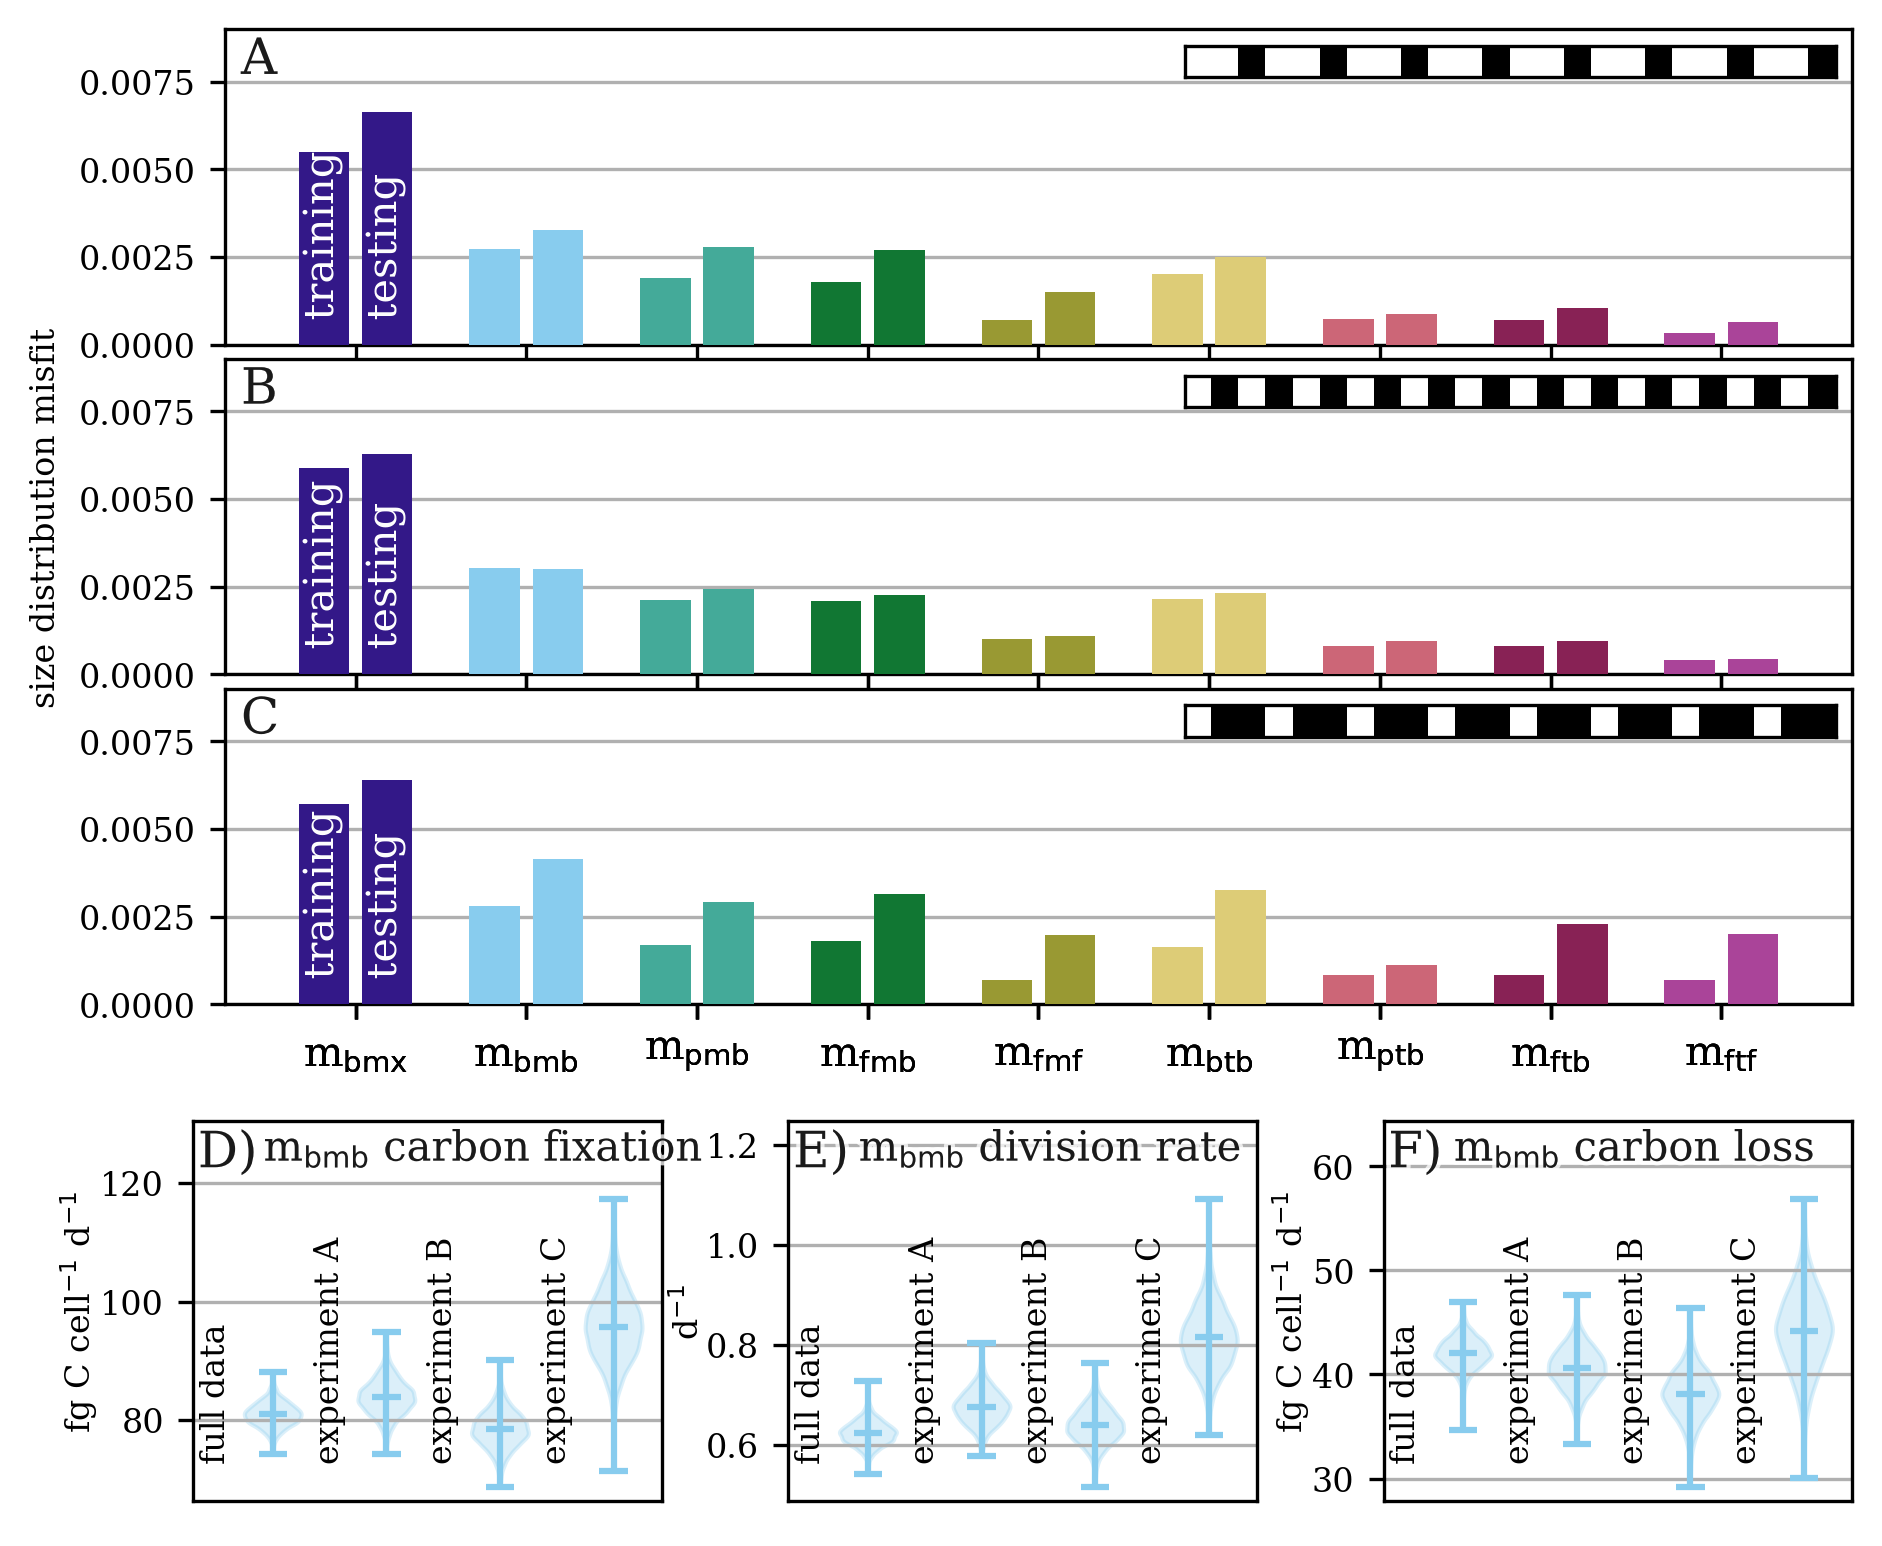

In [12]:
#
# setup
#

def integrate(sample, time):
    dt = np.diff(time)
    return 0.5 * np.sum(dt * (sample[...,1:] + sample[...,:-1]), axis=-1)


def extract_growth(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'growth_vol_gain' in nc_model.variables:
        growth_size_gain = nc_model.variables['growth_vol_gain'][:]
    else:
        growth_size_gain = nc_model.variables['growth_size_gain'][:]
    # units: fg C cell^-1 h^-1
    growth = growth_size_gain/cell_count/dt_h
    if compute_int:
        return (integrate(growth, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return growth, model_time_hours
    

def extract_loss(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    if 'resp_vol_loss' in nc_model.variables:
        resp_size_loss = nc_model.variables['resp_vol_loss'][:]
    else:
        resp_size_loss = nc_model.variables['resp_size_loss'][:]
    # units: fg C cell^-1 h^-1
    loss = resp_size_loss/cell_count/dt_h
    if compute_int:
        return (integrate(loss, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return loss, model_time_hours


def extract_pmax(nc_model, model_time_hours, compute_int=False):
    dt_h = model_time_hours[1] - model_time_hours[0]
    cell_count = nc_model.variables['cell_count'][:]
    max_size_gain = nc_model.variables['max_size_gain'][:]
    pmax = max_size_gain/cell_count/dt_h
    if compute_int:
        return (integrate(pmax, model_time_hours),
                model_time_hours[-1] - model_time_hours[0])
    return pmax, model_time_hours

datafiles = {
    'ref':('../results/zinser_results_full.nc',),
    'expA':('../results/zinser_results_keep_twothirds.nc',),
    'expB':('../results/zinser_results_keep_onehalf.nc',),
    'expC':('../results/zinser_results_keep_onethird.nc',),
}
parameters = {'daily growth':'m_bmb', 'divrate':'m_bmb', 'daily loss':'m_bmb'}
# model_name = 'm_bmb'
exp_names = {'ref':'full data', 'expA':'experiment A', 'expB':'experiment B',
             'expC':'experiment C'}
parameter_desc = {
    'E_star':'E$_k$', 
    'divrate':'division rate', 
    'daily growth':'carbon fixation', 
    'daily loss':'carbon loss',
}

parameter_units = {
    'E_star':'$\mu$mol photons m$^{-2}$ s$^{-1}$', 
    'divrate':'d$^{-1}$', 
    'daily growth':'fg C cell$^{-1}$ d$^{-1}$', 
    'daily loss':'fg C cell$^{-1}$ d$^{-1}$',
}

add_violinlabels = True

model_names = mod_list

#
# get data
#

plotdata = {}

for exp in datafiles:
    plotdata[exp] = {}

    plotdata[exp]['misfit'] = {}
    plotdata[exp]['parameters'] = {}

    for datafile in datafiles[exp]:
        with nc4.Dataset(datafile) as nc:
            for model_name in model_names:
                ncm = nc.groups[model_name]
                plotdata[exp]['i_test'] = ncm.variables['i_test'][:].astype('bool')
                obs = ncm.variables['obs'][:].data
                if model_name not in nc.groups:
                    continue
                mod = nc.groups[model_name].variables['mod_obspos'][:].data
                mod /= np.sum(mod, axis=1)[:,None,:]

                # sum across size class
                e = np.sum((mod-obs[None,:,:])**2, axis=1)

                plotdata[exp]['misfit'][model_name] = np.array((
                    np.mean(np.mean(e, axis=1)),
                    np.mean(np.mean(e[:, plotdata[exp]['i_test'] == 0], axis=1)),
                    np.mean(np.mean(e[:, plotdata[exp]['i_test'] == 1], axis=1)),
                ))

                plotdata[exp]['parameters'][model_name] = {}
                for p in parameters:
                    if model_name == parameters[p]:
                        if p == 'daily growth':
                            model_time_hours = ncm['time'][:]/60
                            plotdata[exp]['parameters'][model_name][p] = (extract_growth(nc.groups[model_name],
                                                                                        model_time_hours=model_time_hours,
                                                                                        compute_int=True)[0]
                                                                          /((model_time_hours[-1]-model_time_hours[0])/24))
                        elif p == 'daily loss':
                            model_time_hours = ncm['time'][:]/60
                            #print((model_time_hours[-1]-model_time_hours[0])/24)
                            plotdata[exp]['parameters'][model_name][p] = (extract_loss(nc.groups[model_name],
                                                                                       model_time_hours=model_time_hours,
                                                                                       compute_int=True)[0]
                                                                          /((model_time_hours[-1]-model_time_hours[0])/24))
                        else:
                            plotdata[exp]['parameters'][model_name][p] = nc.groups[model_name].variables[p][:].data

#
# helper functions
#

def violinplot(ax, dataset, color=None, linewidth=None, **violinplotargs):
    parts = ax.violinplot(dataset, showmeans=True, **violinplotargs)
    
    for part in parts:
        if part == 'bodies':
            for pc in parts[part]:
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
        else:
            parts[part].set_color(color)
    
    if linewidth is not None:
        parts['cbars'].set_linewidth(linewidth)
        parts['cmins'].set_linewidth(linewidth)
        parts['cmaxes'].set_linewidth(linewidth)
    return parts

#
# plotting
#

num_bars = 2
num_data = len(datafiles) - 1
num_params = len(parameters)

fig = plt.figure(figsize=(7, 2 + 1.5*num_data))
axs_bar = np.empty(shape=num_data, dtype=object)
axs_params = np.empty(shape=num_params, dtype=object)

gs_bar = mpl.gridspec.GridSpec(num_data, 1)
gs_bar.update(bottom=0.38, hspace=0.045)

gs_params = mpl.gridspec.GridSpec(1, num_params)
gs_params.update(top=0.32, left=0.11, wspace=0.27)

for i in range(num_data):
    axs_bar[i] = plt.subplot(gs_bar[i,0])
for i in range(num_params):
    axs_params[i] = plt.subplot(gs_params[0,i])

#
# violin plots
#

positions = np.arange(num_data+1)

for p, ax in zip(parameters, axs_params):

    model_name = parameters[p]

    violinplot(ax, [plotdata[exp]['parameters'][model_name][p]
                    for exp in datafiles], 
               positions=positions, color=colors_model[model_name])
    ax.grid(axis='y', zorder=0)
    ax.set(xticks=[])
    ax.set_ylabel(parameter_units[p], labelpad=0)

    if add_violinlabels:
        for iexp, exp in enumerate(datafiles):
            ax.text(positions[iexp]-0.5, 0.1, exp_names[exp],
                    transform=ax.get_xaxis_transform(),  rotation=90,
                    ha='center', va='bottom',
                    size=mpl.rcParams['xtick.labelsize'])
        ax.set_xlim(left=-0.7)
    ylim = ax.get_ylim()
    ax.set_ylim(top = ylim[1] + 0.2 * (ylim[1] - ylim[0]))

#
# bar plots
#

xticks = []
xticklabels = []
gap = 0.7

iax = -1
for exp in datafiles:
    if exp == 'ref':
        continue

    iax += 1
    ax = axs_bar[iax]

    for i,model_name in enumerate(model_names):

        height = plotdata[exp]['misfit'][model_name][-num_bars:]

        x = (num_bars+gap)*i + np.arange(num_bars)
        # zorder = 3 to move in front of bars
        ax.bar(x=x, height=height, color=colors_model[model_name], zorder=3)
        if i == 0:
            for xx, text in zip(x, ['training','testing']):
                ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom',
                        color='white')
        xticks.append(np.mean(x))
        xticklabels.append(desc_model[model_name].replace(',',',\n').replace('(','\n('))

        ax.set(xticks=xticks, xticklabels=[])
        ax.grid(axis='y')

    axins_cbar = inset_axes(ax, width='40%', height='10%', loc='upper right',
                            bbox_to_anchor=(0.0,0.0,1,1),
                            bbox_transform=ax.transAxes)
    axins_cbar.set(xticks=[], yticks=[])
    axins_cbar.pcolormesh(np.arange(len(plotdata[exp]['i_test'])+1), [0, 1],
                          plotdata[exp]['i_test'][None,:], vmin=0, vmax=1,
                          cmap=mpl.cm.Greys)

if num_data % 2 == 1:
    axs_bar[num_data//2].set_ylabel('size distribution misfit')
else:
    axs_bar[num_data//2-1].set_ylabel('size distribution misfit',
                                      horizontalalignment='right', x=1)

axs_bar[-1].set_xticklabels(xticklabels, size=mpl.rcParams['font.size'])

# equalize axes
ylim_top = 0
for ax in axs_bar:
    ylim_top = max(ylim_top, ax.get_ylim()[1])
if ylim_top < 0.009:
    ylim_top = 0.009

for ax in axs_bar:
    ax.set_ylim(top=ylim_top)

#
# add labels
#
    
path_effects=[pe.withStroke(linewidth=2, foreground='white', alpha=0.75)]
ilabel = -1
for ax in axs_bar.flat:
    ilabel += 1
    ax.text(0.01, 0.98, 'ABCDEFG'[ilabel], size=12, ha='left', va='top',
            color='0.1', transform=ax.transAxes, path_effects=path_effects)

iax = -1
for ax, p in zip(axs_params.flat, parameters):
    iax += 1
    ilabel += 1
    ax.text(0.01, 0.98, '{})'.format('ABCDEFG'[ilabel]), size=12, ha='left', va='top',
            color='0.1', transform=ax.transAxes, path_effects=path_effects)
    ax.text(0.15, 0.98, '{} {}'.format(desc_model[parameters[p]], parameter_desc[p]), 
            ha='left', va='top', color='0.1', transform=ax.transAxes,
            path_effects=path_effects)

if save_plots:
    fig.savefig('../figures/zinser_xval.pdf', bbox_inches='tight', dpi=300)

## MC Sampler Chains

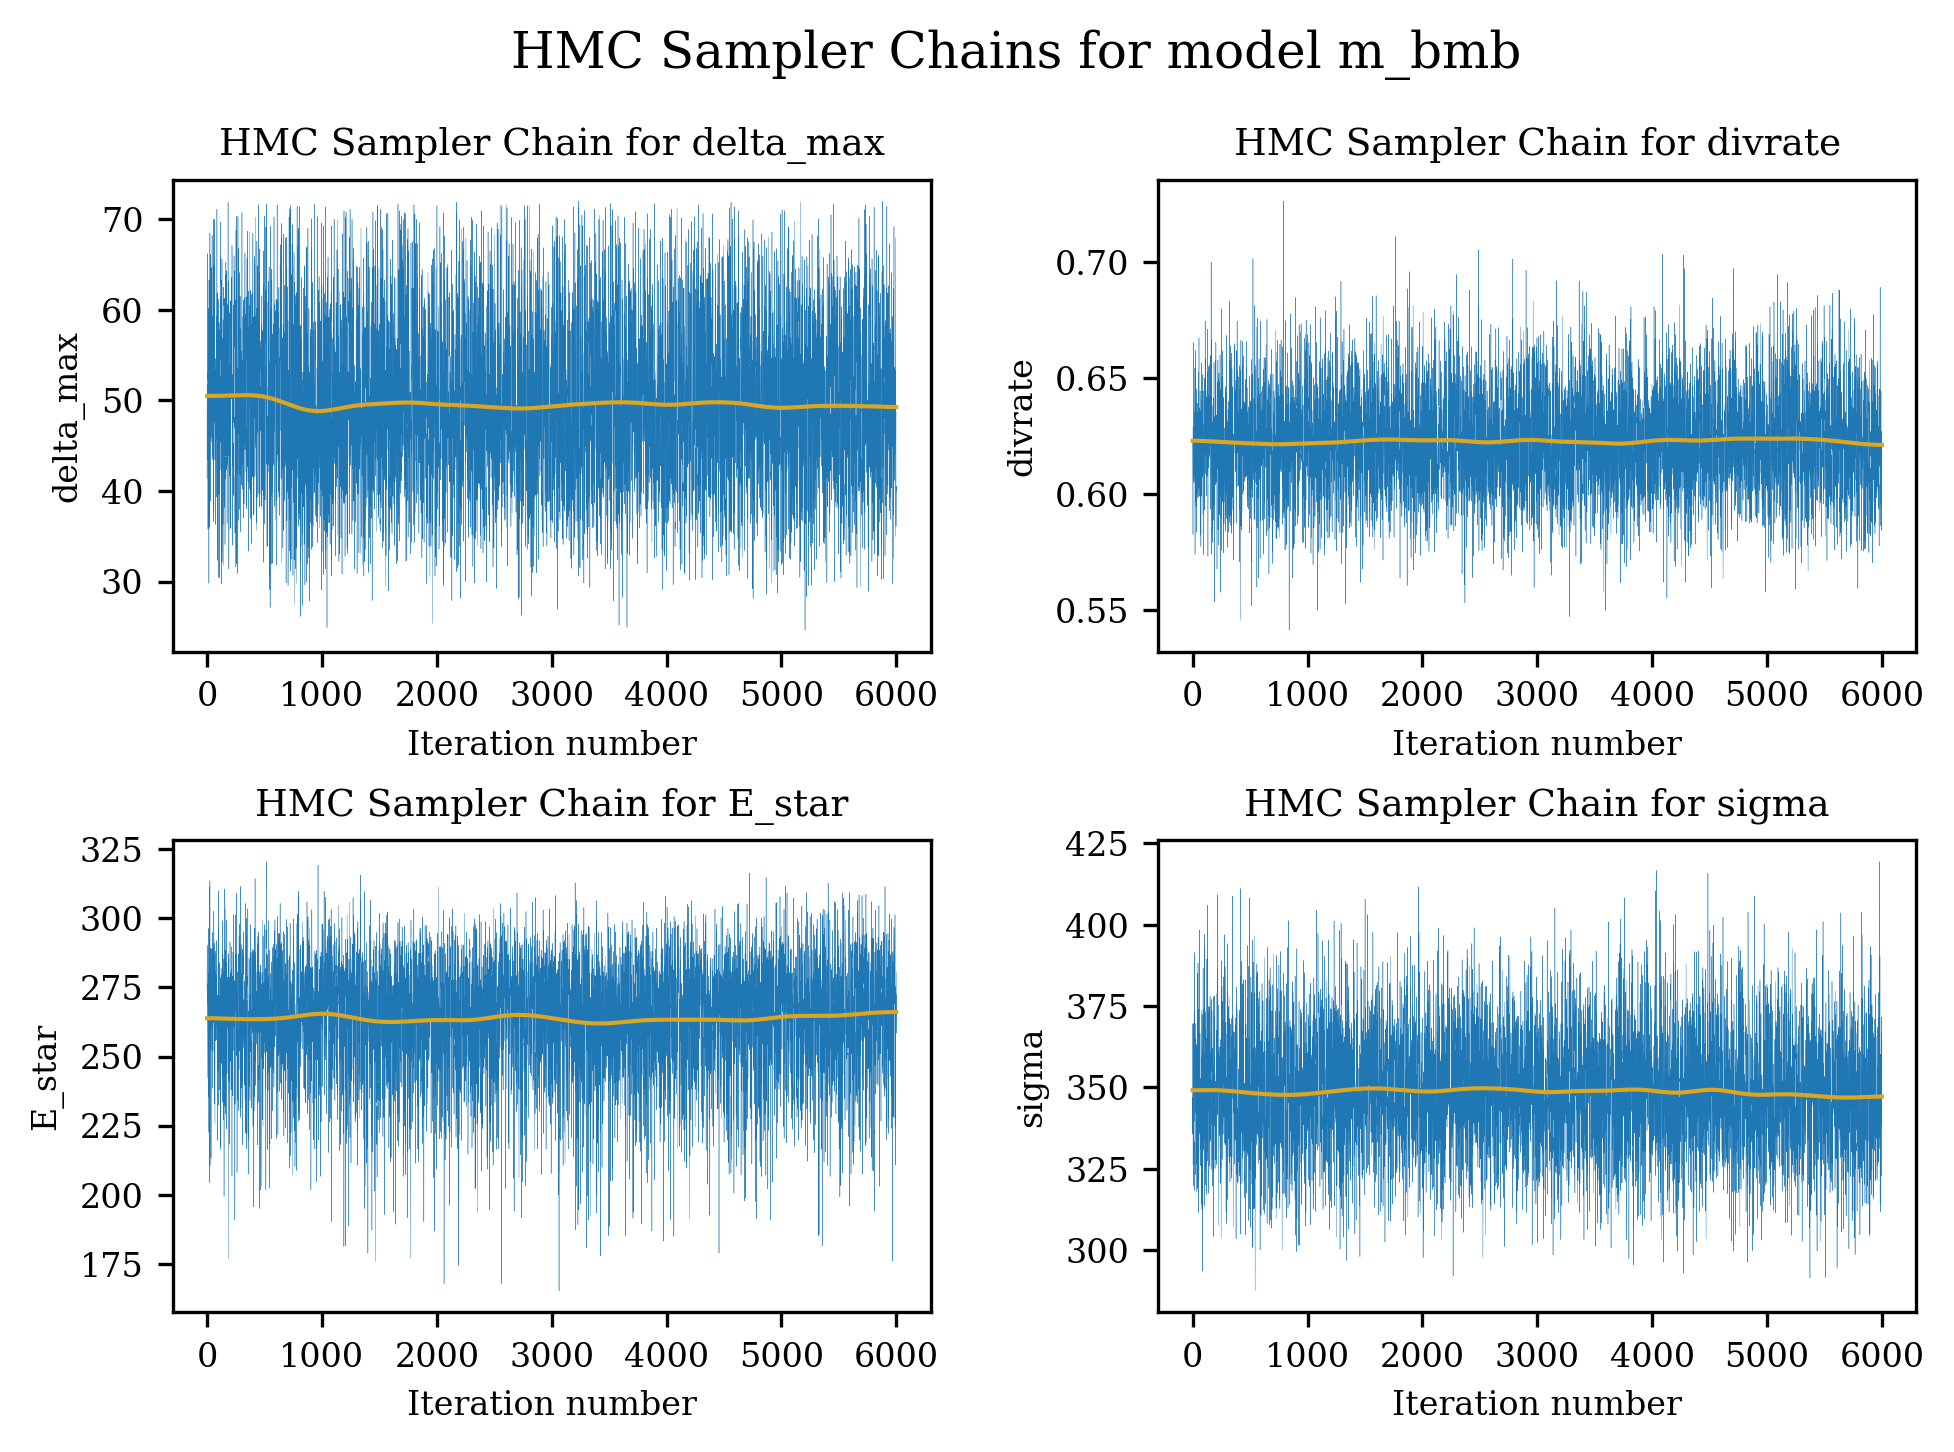

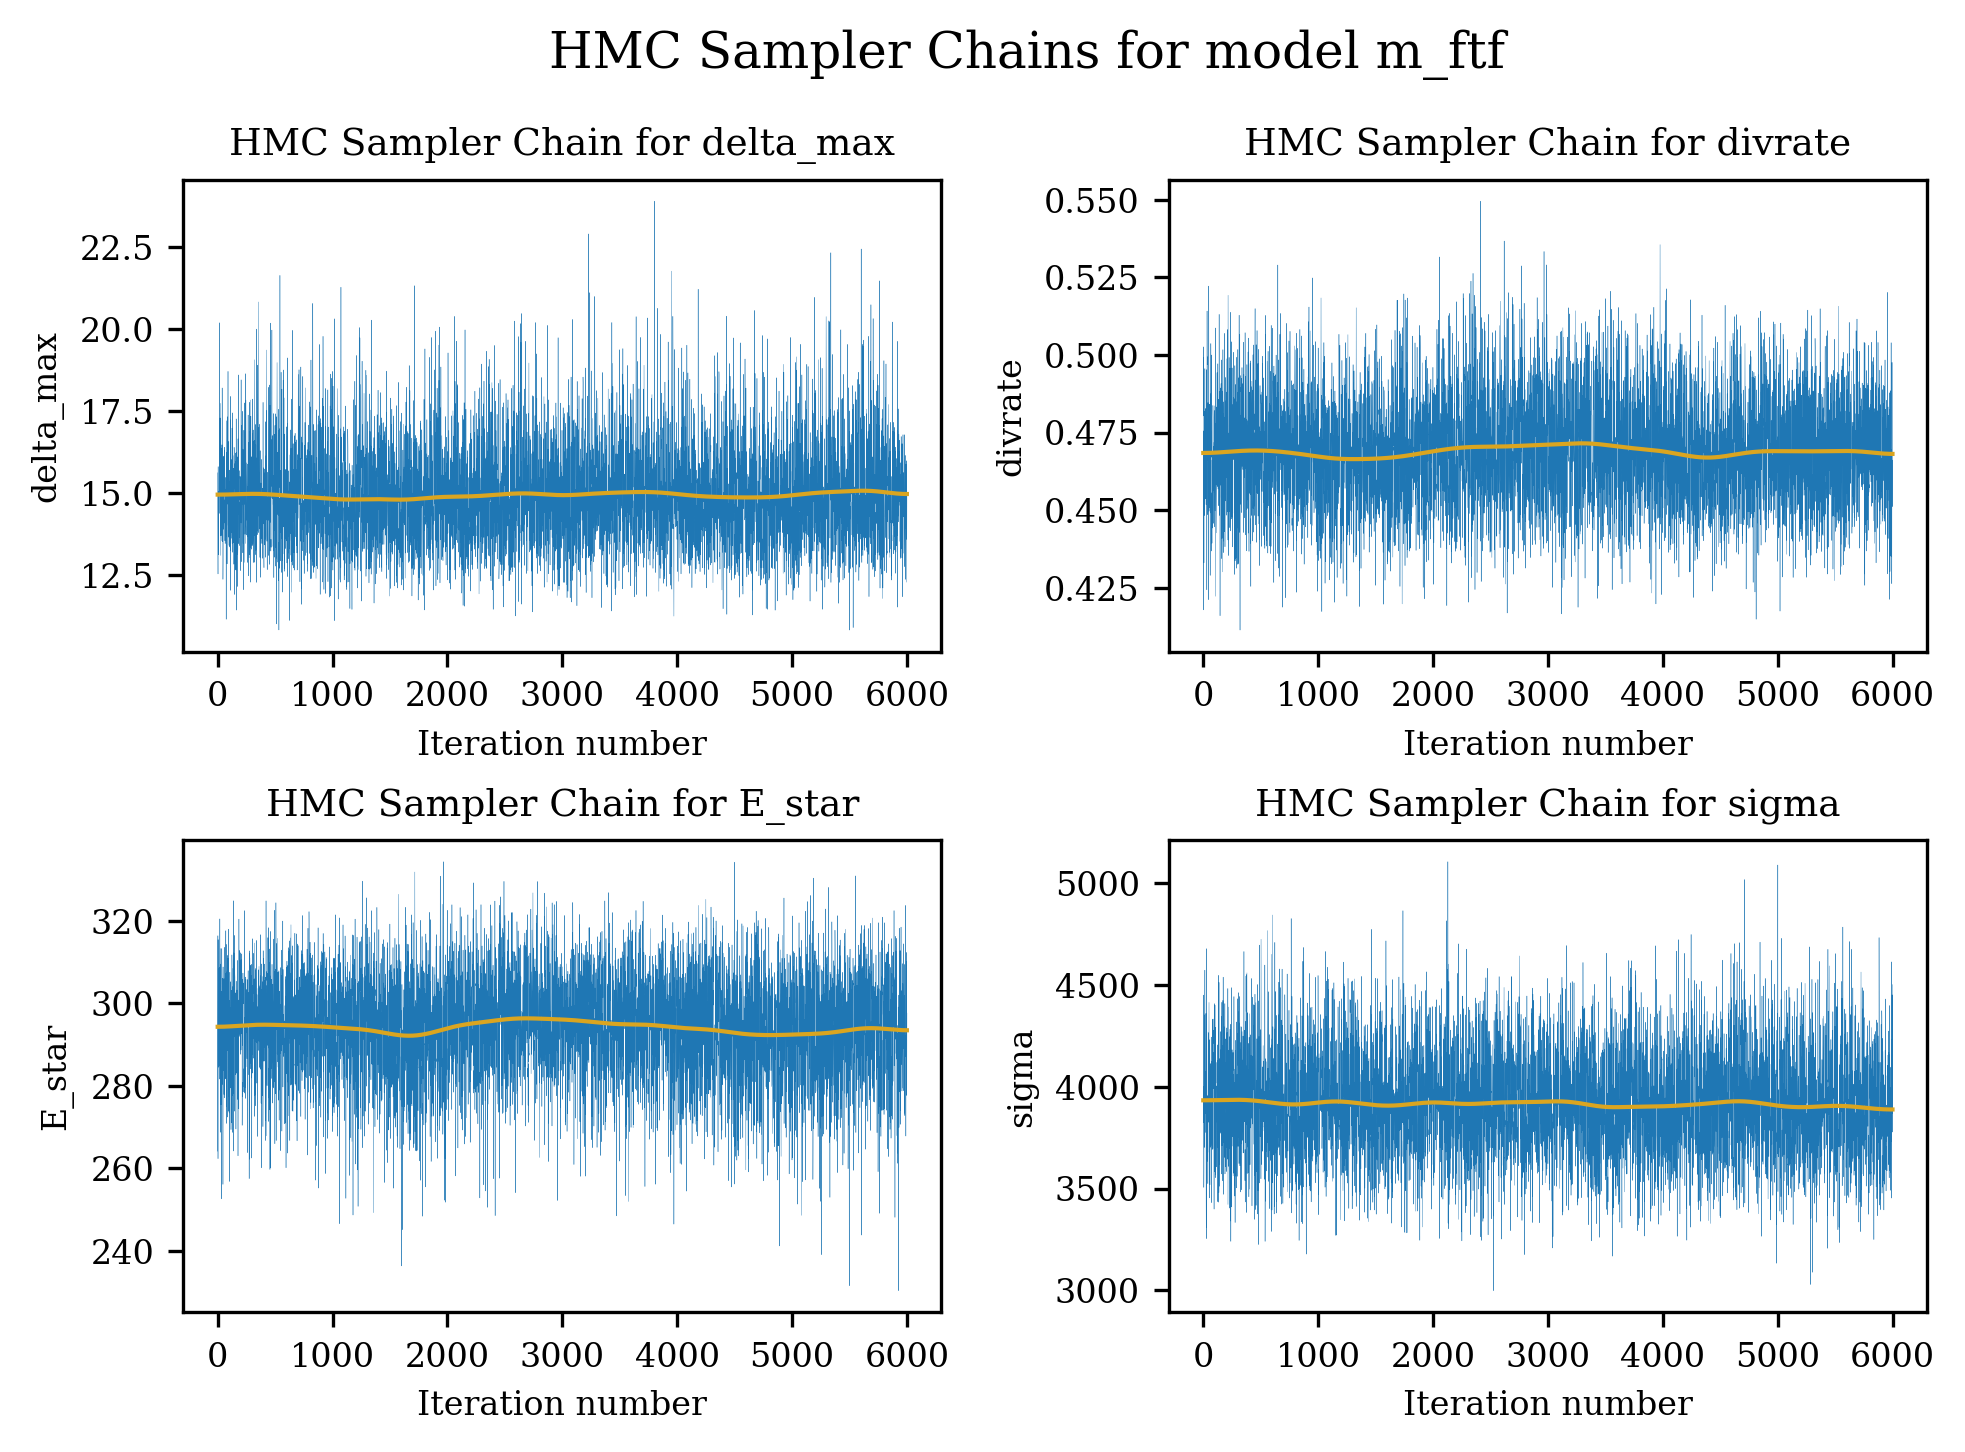

In [13]:
models = ('m_bmb', 'm_ftf')
for mod in models:
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5), squeeze=False,
                            sharex=False)
    fig.suptitle('HMC Sampler Chains for model {}'.format(mod))
    pars = [['delta_max', 'divrate'], ['E_star', 'sigma']]
    for ii in range(2):
        for jj in range(2):
            ax = axs[ii, jj]
            ax.plot(mcmcs[mod][pars[ii][jj]], lw=0.1)
            ax.set_title('HMC Sampler Chain for {}'.format(pars[ii][jj]))
            ax.set_xlabel('Iteration number')
            ax.set_ylabel('{}'.format(pars[ii][jj]))
            ysmoothed = gaussian_filter1d(mcmcs[mod][pars[ii][jj]], sigma=200)
            ax.plot(ysmoothed, lw=1, color='goldenrod')
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    if save_plots:
        plt.savefig('../figures/sampler_chains_{}.pdf'.format(mod),
                    bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

at index  7: marking 14.0h to 16.0h


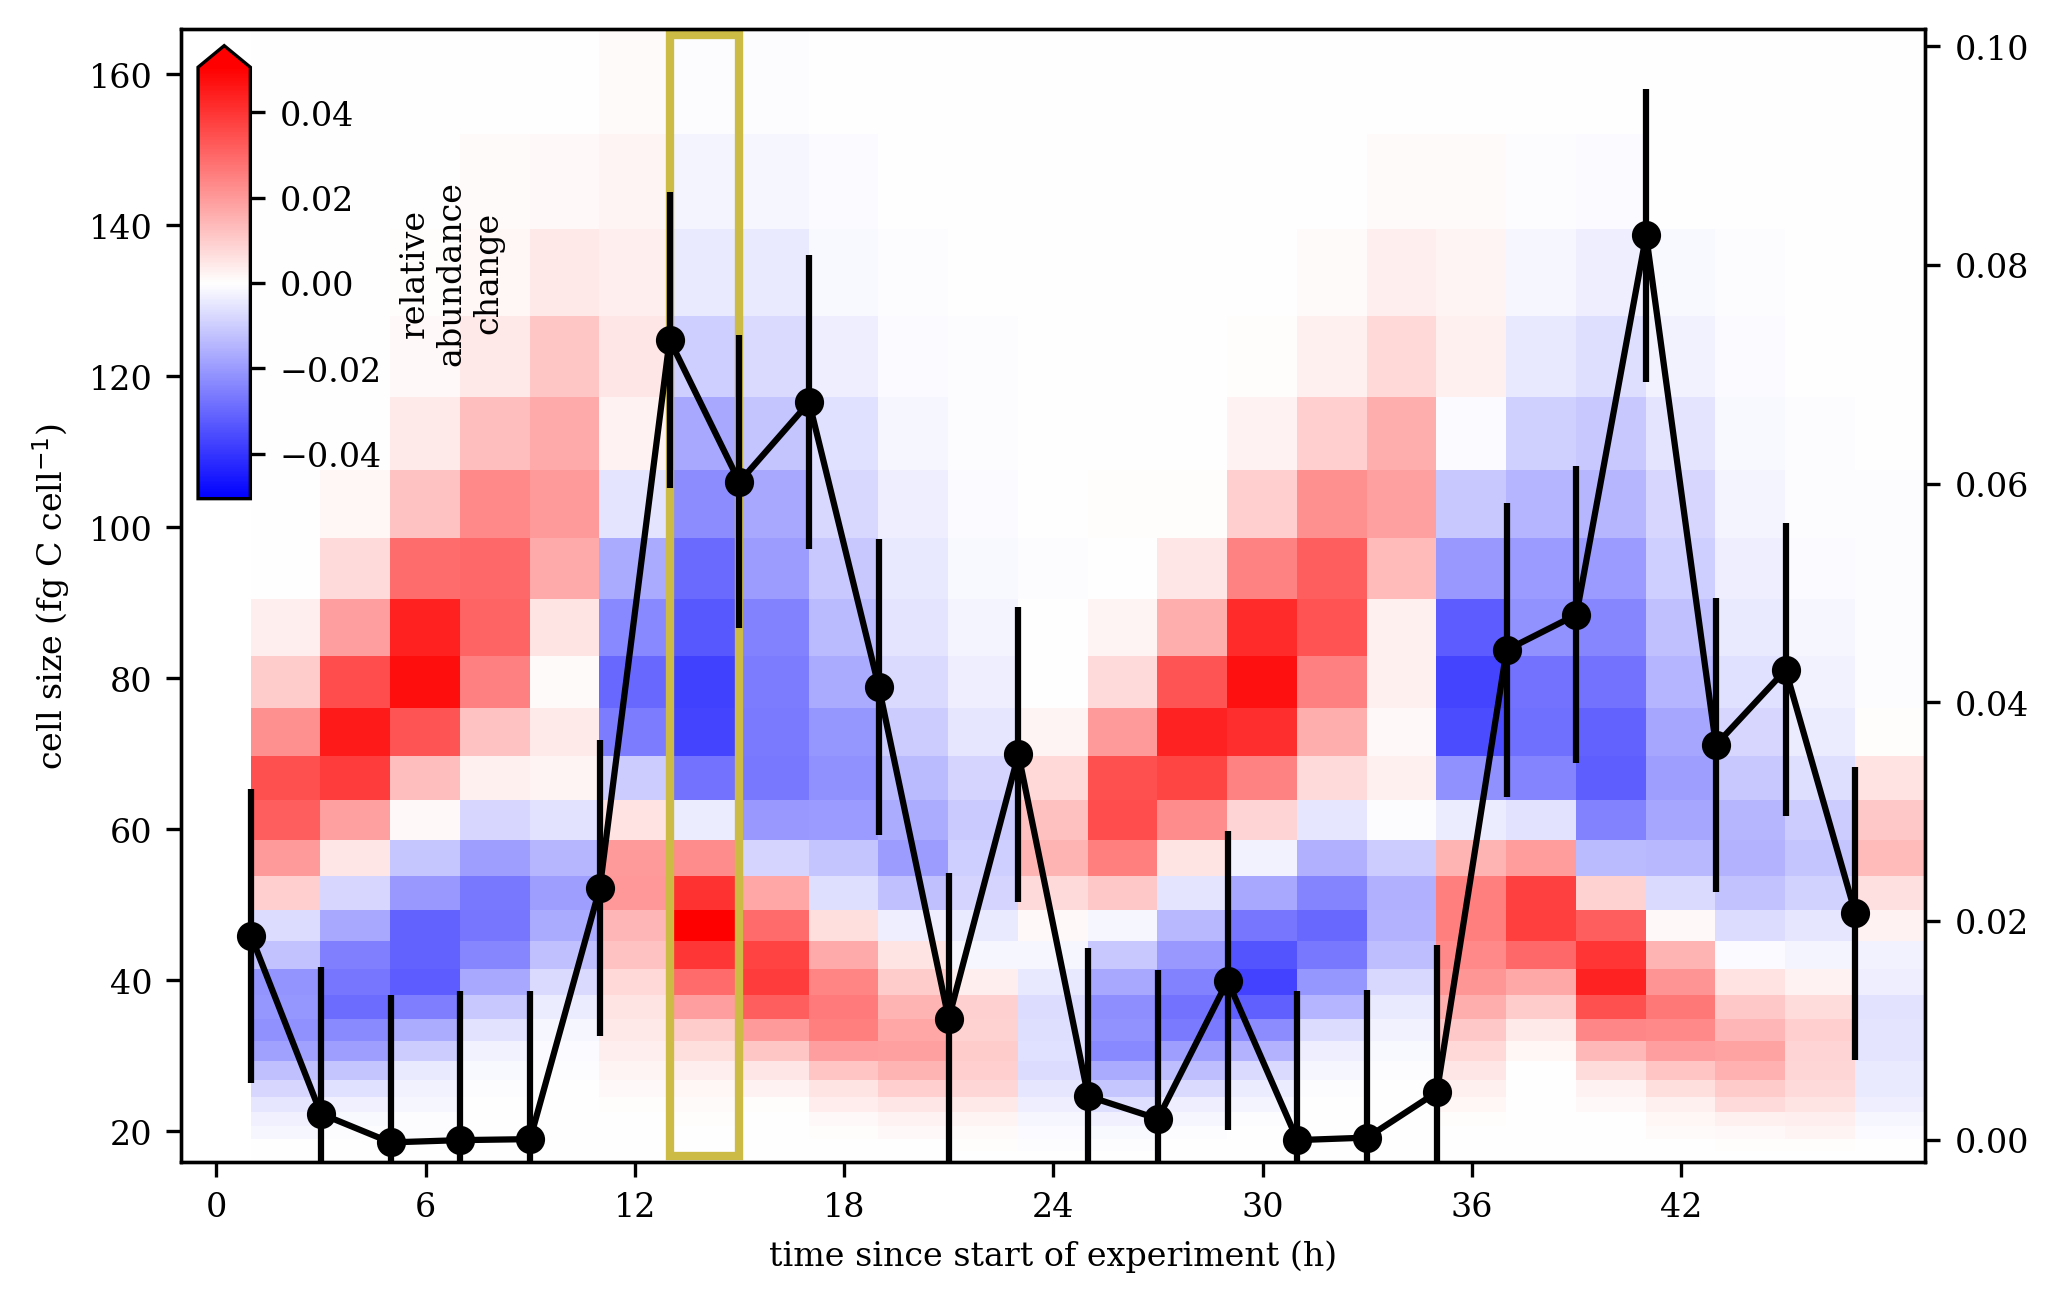

In [16]:
# these determine what gets marked
indices=(7,)

size_bound_edges = v_min * 2**(np.arange(data_gridded['m'] + 1) * delta_v)
t = data_gridded['time']/60
t_edges = np.empty(t.size+1)
t_edges[1:-1] = 0.5 * (t[1:] +t[:-1])
t_edges[0] = 0.5 * (t[0] - t[1])
t_edges[-1] = t[-1] + 0.5*(t[-1]-t[-2])

prop_labels = {
    'size':'cell size (fg C cell$^{-1}$)',
    'growth':'carbon fixation (fg C cell$^{-1}$ h$^{-1}$)',
    'growthresp':'carbon fixation and loss\n(fg C cell$^{-1}$ h$^{-1}$)',
    'division':'division rate (h$^{-1}$)',
    'respiration':'carbon loss (fg C cell$^{-1}$ h$^{-1}$)',
    'abundance':'abundance (cells ml$^{-1}$)',
    'light':'PAR ($\\mu$mol photons m$^{-2}$ s$^{-1}$)',
}

prop_colors = {
    'growth':'#0077bb',
    'division':'black',
    'respiration':'#009988',
    'abundance':'black',  
    'light':'#ee7733',    
}

colors = ('#ccbb44',)
        
size_bound_centers  = 0.5 * (size_bound_edges[1:] + size_bound_edges[:-1])

units = 'h'

#
# plotting
#

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))    

def add_colorbar(ax, label=None, labelcolor='0.9', **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='40%', loc='upper left',
                            bbox_to_anchor=(0.0,0.0,1,1),
                            bbox_transform=ax.transAxes)
    cb = mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                                   **cbarargs)
    cb.set_label(label, color=labelcolor)
    for ytl in cb.ax.get_yticklabels():
        ytl.set_color(labelcolor)
    cb.ax.tick_params(axis='y', colors=labelcolor)
    cb.outline.set_edgecolor(labelcolor)

#
# pcolor
#

#         tmp = data_gridded['w_obs']
tmp = data_gridded['w_obs'][:, 1:] - data_gridded['w_obs'][:, :-1]
label = 'relative\nabundance\nchange'

max_val = np.max(np.abs(tmp))

norm = mpl.colors.Normalize(vmax=max_val, vmin=-max_val)
pc = ax.pcolormesh(t_edges[1:], size_bound_edges, tmp, norm=norm,
                   rasterized=True, cmap='bwr')

add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label=label, labelcolor='black', extend='max')

ax.set(xlabel='time since start of experiment ({})'.format(units),
       ylabel=prop_labels['size'])

ax_div = ax.twinx()
prop = 'division'
ax_div.errorbar(ground_truth['division_time'], ground_truth['division'],
                yerr=ground_truth['division_sd'], color=prop_colors[prop],
                marker='o', label='division')

ax.set_xticks(np.arange(0,48,6))
dt = t[1] - t[0]
ax.set_xlim((t[0] - 0.5 * dt, t[-1] + 0.5 * dt))

ax_div.tick_params(axis='y', colors=prop_colors[prop])
ax_div.spines['right'].set_color(prop_colors[prop])
ax_div.set_ylim(bottom=-0.002) # to allow markers to appear fully
for ytl in ax_div.get_yticklabels():
    ytl.set_color(prop_colors[prop])
    
# set markers
for index, color in zip(indices, colors):
    print('at index {0:2d}: marking {2}{1} to {3}{1}'.format(index, units,
                                                             t[index],
                                                             t[index+1]))
    rect = mpl.patches.Rectangle((t[index]-1,0.005), width=t[1]-t[0],
                                 height=1-2*0.005, lw=2,fc='none', ec=color,
                                 transform=ax.get_xaxis_transform())
    ax.add_artist(rect)

if save_plots:
    plt.savefig('../figures/size_change.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [17]:
plt.close('all')